In [1]:
import os
import io
import trimesh
import b3d
import genjax
import jax
import b3d.bayes3d as bayes3d
import jax.numpy as jnp
import numpy as np
import rerun as rr
from PIL import Image
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
from genjax import Pytree
import b3d.chisight.dense.dense_model
import b3d.chisight.dense.likelihoods.laplace_likelihood
# from genjax._src.core.serialization.msgpack import msgpack_serialize

## define helper functions

In [2]:
def scale_mesh(vertices, scale_factor):
    vertices[:, 0] *= scale_factor[0]
    vertices[:, 1] *= scale_factor[1]
    vertices[:, 2] *= scale_factor[2]
    return vertices

def euler_angles_to_quaternion(euler: np.ndarray) -> np.ndarray:
    """
    Convert Euler angles to a quaternion.

    Source: https://pastebin.com/riRLRvch

    :param euler: The Euler angles vector.

    :return: The quaternion representation of the Euler angles.
    """
    pitch = np.radians(euler[0] * 0.5)
    cp = np.cos(pitch)
    sp = np.sin(pitch)

    yaw = np.radians(euler[1] * 0.5)
    cy = np.cos(yaw)
    sy = np.sin(yaw)

    roll = np.radians(euler[2] * 0.5)
    cr = np.cos(roll)
    sr = np.sin(roll)

    x = sy * cp * sr + cy * sp * cr
    y = sy * cp * cr - cy * sp * sr
    z = cy * cp * sr - sy * sp * cr
    w = cy * cp * cr + sy * sp * sr
    return np.array([x, y, z, w])

def get_mask_area(color, seg_img):
    arr = seg_img == color
    arr = arr.min(-1).astype('float')
    arr = arr.reshape((arr.shape[-1], arr.shape[-1]))
    return arr.astype(bool)

def unproject_pixels(mask, depth_map, cam_matrix, fx, fy, vfov=54.43222, near_plane=0.1, far_plane=100):
    '''
    pts: [N, 2] pixel coords
    depth: [N, ] depth values
    returns: [N, 3] world coords
    '''
    depth = depth_map[mask]
    pts = np.array([[x,y] for x,y in zip(np.nonzero(mask)[0], np.nonzero(mask)[1])])
    camera_matrix = np.linalg.inv(cam_matrix.reshape((4, 4)))

    # Different from real-world camera coordinate system.
    # OpenGL uses negative z axis as the camera front direction.
    # x axes are same, hence y axis is reversed as well.
    # Source: https://learnopengl.com/Getting-started/Camera
    rot = np.array([[1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1]])
    camera_matrix = np.dot(camera_matrix, rot)


    height = depth_map.shape[0]
    width = depth_map.shape[1]

    img_pixs = pts[:, [1, 0]].T
    img_pix_ones = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    intrinsics = np.array([[fx, 0, width/ 2.0],
                           [0, fy, height / 2.0],
                           [0, 0, 1]])
    img_inv = np.linalg.inv(intrinsics[:3, :3])
    cam_img_mat = np.dot(img_inv, img_pix_ones)

    points_in_cam = np.multiply(cam_img_mat, depth.reshape(-1))
    points_in_cam = np.concatenate((points_in_cam, np.ones((1, points_in_cam.shape[1]))), axis=0)
    points_in_world = np.dot(camera_matrix, points_in_cam)
    points_in_world = points_in_world[:3, :].T#.reshape(3, height, width)
    points_in_cam = points_in_cam[:3, :].T#.reshape(3, height, width)
    
    return points_in_world

def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


## load basic information from hdf5

In [3]:
# paths for reading physion metadata
physion_assets_path = os.path.join(
    b3d.get_root_path(),
    "assets/physion/",)

# stim_name = 'lf_0/dominoes_all_movies/pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0012'
stim_name = '0012_support'

hdf5_file_path = os.path.join(physion_assets_path,
    f"{stim_name}.hdf5",
)

mesh_file_path = os.path.join(physion_assets_path,
    f"all_flex_meshes/",
)

In [4]:
vfov = 54.43222 
near_plane = 0.1
far_plane = 100
depth_arr = []
image_arr = []
with h5py.File(hdf5_file_path, "r") as f:
    # extract depth info
    for key in f['frames'].keys():
        depth = jnp.flip(jnp.array(f['frames'][key]['images']['_depth_cam0']), 0)
        depth_arr.append(depth)
        image = jnp.array(Image.open(io.BytesIO(f['frames'][key]['images']['_img_cam0'][:])))
        image_arr.append(image)
    depth_arr = jnp.asarray(depth_arr)
    image_arr = jnp.asarray(image_arr)/255
    FINAL_T, height, width = image_arr.shape[0], image_arr.shape[1], image_arr.shape[2]

    # extract camera info
    camera_azimuth = np.array(f['azimuth']['cam_0'])
    camera_matrix = np.array(f['frames']['0000']['camera_matrices']['camera_matrix_cam0']).reshape((4, 4))
    projection_matrix = np.array(f['frames']['0000']['camera_matrices']['projection_matrix_cam0']).reshape((4, 4))
    im_seg = np.array(Image.open(io.BytesIO(f['frames']['0000']['images']['_id_cam0'][:])))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    vfov = vfov / 180.0 * np.pi
    tan_half_vfov = np.tan(vfov / 2.0)
    tan_half_hfov = tan_half_vfov * width / float(height)
    fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
    fy = height / 2.0 / tan_half_vfov

    # extract object info
    object_ids = np.array(f['static']['object_ids'])
    model_names = np.array(f['static']['model_names'])
    assert len(object_ids) == len(model_names)
    object_segmentation_colors = np.array(f['static']['object_segmentation_colors'])
    initial_position = np.array(f['static']['initial_position'])
    initial_rotation = np.array(f['static']['initial_rotation'])
    scales = np.array(f['static']['scale'])

## b3d modeling

In [5]:
rr.init("demo")
rr.connect("127.0.0.1:8812")
rr.log("/", rr.ViewCoordinates.LEFT_HAND_Y_UP, static=True)  # Set an up-axis

In [6]:
counter = np.unique(im_seg.reshape(-1, im_seg.shape[2]), axis=0)
num_obj = counter.shape[0]-1

In [7]:
# object_meshes = []
# for idx, model_name in enumerate(model_names):
#     trim = trimesh.load(os.path.join(mesh_file_path, f"{model_name.decode('UTF-8')}.obj"))
#     object_meshes.append((scale_mesh(trim.vertices, scales[idx]), trim.faces))
# print(len(object_meshes))

In [8]:
# skipping the object id inference step, directly assume that we know which segment corresponds to which mesh
START_T = 0
pose_mesh_color_from_point_cloud = []
for (model_name, scale, color) in zip(model_names, scales, object_segmentation_colors):
    area = get_mask_area(im_seg, color)
    point_cloud = jnp.asarray(unproject_pixels(area, depth_arr[START_T], camera_matrix, fx, fy))
    point_cloud_centroid = point_cloud.mean(0)
    point_cloud_bottom = min(point_cloud[:,1])
    object_pose = b3d.Pose.from_translation(np.array([point_cloud_centroid[0], point_cloud_bottom, point_cloud_centroid[2]]))
    object_colors = jnp.asarray(image_arr[START_T][area])
    mean_object_colors = np.mean(object_colors, axis=0)
    trim = trimesh.load(os.path.join(mesh_file_path, f"{model_name.decode('UTF-8')}.obj"))
    mesh_info = (scale_mesh(trim.vertices, scale), trim.faces, jnp.ones(trim.vertices.shape)*mean_object_colors)
    pose_mesh_color_from_point_cloud.append((object_pose, mesh_info))

In [9]:
# %matplotlib widget

# for idx, (_, mesh) in enumerate(pose_mesh_color_from_point_cloud):
#       print(idx)
#       fig = plt.figure()
#       ax = fig.add_subplot(projection='3d')
#       ax.set_box_aspect([1,1,1])
#       ax.plot_trisurf(mesh[0][:, 0], mesh[0][:,2], mesh[0][:,1], triangles=mesh[1], color=np.mean(mesh[2], axis=0).tolist())
#       set_axes_equal(ax)

In [10]:
# %matplotlib widget

# START_T = 0
# # all_object_poses = []
# pose_color_from_point_cloud = []
# for color in counter:
#     if not np.array_equal(color,  np.array([0,0,0])):
#         area = get_mask_area(im_seg, color)
#         point_cloud = jnp.asarray(unproject_pixels(area, depth_arr[START_T], camera_matrix, fx, fy))
#         point_cloud_centroid = point_cloud.mean(0)
#         point_cloud_bottom = min(point_cloud[:,1])
#         object_pose = b3d.Pose.from_translation(np.array([point_cloud_centroid[0], point_cloud_bottom, point_cloud_centroid[2]]))
#         object_colors = jnp.asarray(image_arr[START_T][area])
#     pose_color_from_point_cloud.append((object_pose, object_colors))



#         # # Create new mesh.
#         img_seg_colors = jnp.asarray(image_arr[START_T][area])
#         # point_cloud_colors = jnp.full(image_arr[START_T][area].shape, 1)
#         # vertices, faces, vertex_colors, _face_colors = (
#         #     b3d.make_mesh_from_point_cloud_and_resolution(
#         #         point_cloud, point_cloud_colors, point_cloud[:, 2] / fx * 2.0
#         #     )
#         # )
#         # fig = plt.figure()
#         # ax = fig.add_subplot(projection='3d')
#         # ax.set_box_aspect([1,1,1])
#         # ax.plot_trisurf(vertices[:, 0], vertices[:,2], vertices[:,1], triangles=faces)
#         # set_axes_equal(ax)
#         # object_pose = b3d.Pose.from_translation(vertices.mean(0))
#         # all_object_poses.append(object_pose)

In [11]:
all_object_poses_gt = []
for idx in range(len(object_ids)):
    object_pose = b3d.Pose(jnp.asarray(initial_position[idx]), jnp.asarray(euler_angles_to_quaternion(initial_rotation[idx])))
    all_object_poses_gt.append(object_pose)
all_object_poses_gt

[Pose(position=Array([0., 0., 0.], dtype=float32), quaternion=Array([0., 0., 0., 1.], dtype=float32)),
 Pose(position=Array([-1.,  0.,  0.], dtype=float32), quaternion=Array([0., 0., 0., 1.], dtype=float32)),
 Pose(position=Array([-0.09289116,  0.01      , -0.0183087 ], dtype=float32), quaternion=Array([0.        , 0.12470054, 0.        , 0.9921944 ], dtype=float32)),
 Pose(position=Array([-0.03169015,  0.51278937,  0.01329252], dtype=float32), quaternion=Array([ 0.        , -0.6408473 ,  0.        ,  0.76766837], dtype=float32)),
 Pose(position=Array([-0.039348  ,  1.0667564 , -0.02199401], dtype=float32), quaternion=Array([ 0.        , -0.45416597,  0.        ,  0.8909171 ], dtype=float32)),
 Pose(position=Array([0.       , 1.6315545, 0.       ], dtype=float32), quaternion=Array([0., 0., 0., 1.], dtype=float32))]

In [12]:
object_library = []
for (_, obj) in pose_mesh_color_from_point_cloud:
    object_library.append(b3d.Mesh(obj[0], obj[1], obj[2]))

print(f"{len(object_library)} objects in library")

6 objects in library


In [13]:
R = camera_matrix[:3,:3]
T = camera_matrix[0:3, 3]
a = np.array([-R[0,:], -R[1,:], -R[2,:]])
b = np.array(T)
camera_position_from_matrix = np.linalg.solve(a, b)
camera_rotation_from_matrix = -np.transpose(R)
camera_pose = b3d.Pose(
    camera_position_from_matrix,
    b3d.Rot.from_matrix(camera_rotation_from_matrix).as_quat()
)

In [14]:
# Defines the enumeration schedule.
scaling_factor = 1.0
renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor,
    height * scaling_factor,
    fx * scaling_factor,
    fy * scaling_factor,
    (width/2) * scaling_factor,
    (height/2) * scaling_factor,
    near_plane,
    far_plane,
)

b3d.reload(b3d.chisight.dense.dense_model)
b3d.reload(b3d.chisight.dense.likelihoods.laplace_likelihood)
likelihood_func = b3d.chisight.dense.likelihoods.laplace_likelihood.likelihood_func
model, viz_trace, info_from_trace = (
    b3d.chisight.dense.dense_model.make_dense_multiobject_model(
        renderer, likelihood_func
    )
)
importance_jit = jax.jit(model.importance)

likelihood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "image_width": Pytree.const(renderer.width),
    "image_height": Pytree.const(renderer.height),
}


/home/hlwang_ipe_genjax/b3d/.pixi/envs/gpu/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [15]:
# Gridding on translation only.
translation_deltas = b3d.Pose.concatenate_poses(
    [
        jax.vmap(lambda p: b3d.Pose.from_translation(p))(
            jnp.stack(
                jnp.meshgrid(
                    jnp.linspace(-0.2, 0.2, 11),
                    jnp.linspace(-0.2, 0.2, 11),
                    jnp.linspace(-0.2, 0.2, 11),
                ),
                axis=-1,
            ).reshape(-1, 3)
        ),
        b3d.Pose.identity()[None, ...],
    ]
)
# Sample orientations from a VMF to define a "grid" over orientations.
rotation_deltas = b3d.Pose.concatenate_poses(
    [
        jax.vmap(b3d.Pose.sample_gaussian_vmf_pose, in_axes=(0, None, None, None))(
            jax.random.split(jax.random.PRNGKey(0), 11 * 11 * 11),
            b3d.Pose.identity(),
            0.0001,
            100.0,
        ),
        b3d.Pose.identity()[None, ...],
    ]
)
all_deltas = b3d.Pose.stack_poses([translation_deltas, rotation_deltas])

In [16]:
rgbds = jnp.concatenate([jnp.flip(image_arr,2), jnp.reshape(jnp.flip(depth_arr,2), depth_arr.shape+(1,))], axis=-1)
rgbds.shape

(474, 350, 350, 4)

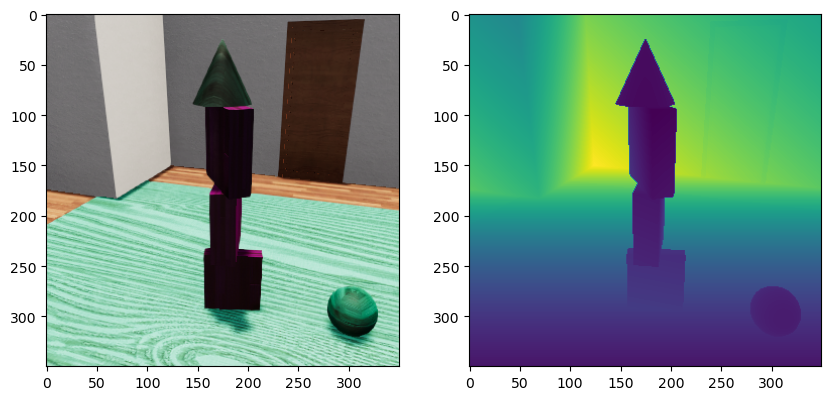

In [17]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(121)
ax.imshow(rgbds[START_T][..., 0:3])

ax = fig.add_subplot(122)
ax.imshow(rgbds[START_T][..., -1])

In [18]:
# Initial trace for timestep 0
choice_map = dict([("camera_pose", camera_pose), 
                   ("rgbd", rgbds[START_T]), 
                   ("depth_noise_variance", 0.005),
                   ("color_noise_variance", 0.1),
                   ("outlier_probability", 0.1)] + 
                   [(f"object_pose_{idx}", pose_mesh_color_from_point_cloud[idx][0]) for idx in range(num_obj)] + 
                   [(f"object_{idx}", idx) for idx in range(num_obj)])

trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.ChoiceMap.d(
        choice_map
    ),
    (
        {
            "num_objects": Pytree.const(num_obj),
            "meshes": object_library,
            "likelihood_args": likelihood_args,
        },
    ),
)

key = jax.random.PRNGKey(0)
for idx in range(num_obj):
    print(idx)
    trace, key = bayes3d.enumerate_and_select_best_move(
        trace, Pytree.const((f"object_pose_{idx}",)), key, all_deltas
    )

viz_trace(trace, START_T)

0
1
2
3
4
5


In [19]:
# with open("/home/hlwang_ipe_genjax/b3d/saved_traces/test.pickle", "wb") as output_file:
#     msgpack_serialize.dump(trace, output_file)

In [20]:
# with open("/home/hlwang_ipe_genjax/b3d/saved_traces/test.pickle", "rb") as output_file:
#     retrieved_tr = msgpack_serialize.load(output_file, model, (jnp.arange(3), model_args, object_library))
# bayes3d.rerun_visualize_trace_t(retrieved_tr, 0)

In [21]:
FINAL_T = len(image_arr)
for T_observed_image in tqdm(range(FINAL_T)):
    # Constrain on new RGB and Depth data.
    trace = b3d.update_choices(
        trace,
        Pytree.const(("rgbd",)),
        rgbds[T_observed_image],
    )
 
    for idx in range(num_obj):
        trace, key = bayes3d.enumerate_and_select_best_move(
            trace, Pytree.const((f"object_pose_{idx}",)), key, all_deltas
        )
    # bayes3d.rerun_visualize_trace_t(trace, T_observed_image)
    viz_trace(trace, T_observed_image)

  7%|▋         | 32/474 [00:41<09:27,  1.28s/it]


KeyboardInterrupt: 